## **SemEval-2017 Task 4: Sentiment Analysis in Twitter (Natural Language Processing 7120 CEM (CW1))**


This notebook contains my the code for course work 1 (Natural Language Processing). The task I have chosen is to predict the sentiment of a tweet. This task is a shared task developed by the International Workshop on Semantic Evaluation (SemEval).

Link to dataset: https://www.dropbox.com/scl/fi/23fj2ev76mh746vpnyeee/2017_English_final.zip?rlkey=swyaaabubmtzyhrh020bmfk1j&e=1

### Import Necessary Libraries


In [ ]:
%pip install emoji
import emoji
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import re
import seaborn as sns
import string
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from wordcloud import WordCloud
from xgboost import XGBClassifier # type: ignore
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 11.9 MB/s eta 0:00:00


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Step 1: Load Dataset

In [ ]:
#upload files
from google.colab import files
uploaded = files.upload()

Saving twitter-2013dev-A.txt to twitter-2013dev-A.txt
Saving twitter-2013test-A.txt to twitter-2013test-A.txt
Saving twitter-2013train-A.txt to twitter-2013train-A.txt
Saving twitter-2014sarcasm-A.txt to twitter-2014sarcasm-A.txt
Saving twitter-2014test-A.txt to twitter-2014test-A.txt
Saving twitter-2015test-A.txt to twitter-2015test-A.txt
Saving twitter-2015train-A.txt to twitter-2015train-A.txt
Saving twitter-2016dev-A.txt to twitter-2016dev-A.txt
Saving twitter-2016devtest-A.txt to twitter-2016devtest-A.txt
Saving twitter-2016test-A.txt to twitter-2016test-A.txt
Saving twitter-2016train-A.txt to twitter-2016train-A.txt


In [ ]:
#load the dataset

file_path = [r"/content/twitter-2013dev-A.txt",
r"/content/twitter-2013test-A.txt",
r"/content/twitter-2013train-A.txt",
r"/content/twitter-2014test-A.txt",
r"/content/twitter-2015test-A.txt",
r"/content/twitter-2015train-A.txt",
r"/content/twitter-2016dev-A.txt",
r"/content/twitter-2016devtest-A.txt",
r"/content/twitter-2016test-A.txt",
r"/content/twitter-2016train-A.txt"
]

def merge_files(paths: 'list of file paths') -> pd.DataFrame:
    join_df = pd.DataFrame()
    for file in paths:
        df = pd.read_csv(file, sep ='\t', header = None)
        join_df = pd.concat([join_df, df], ignore_index=True)
    return join_df

merged_df = merge_files(file_path)

In [ ]:
#Shape of dataframes
for file in file_path:
    df = pd.read_csv(file, sep ='\t', header = None)
    print(file, df.shape)

/content/twitter-2013dev-A.txt (1654, 3)
/content/twitter-2013test-A.txt (3547, 3)
/content/twitter-2013train-A.txt (9684, 3)
/content/twitter-2014test-A.txt (1853, 3)
/content/twitter-2015test-A.txt (2390, 3)
/content/twitter-2015train-A.txt (489, 3)
/content/twitter-2016dev-A.txt (1966, 3)
/content/twitter-2016devtest-A.txt (2000, 3)
/content/twitter-2016test-A.txt (20632, 4)
/content/twitter-2016train-A.txt (5868, 3)


### Step 2: Exploratory Data Analysis

Let us examine our data properties before we clean and process it.

In [ ]:
#Explore properties of data
print(merged_df.shape)
print(merged_df.info())
merged_df[:2]

(50083, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50083 entries, 0 to 50082
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       50083 non-null  int64 
 1   1       50083 non-null  object
 2   2       50083 non-null  object
 3   3       10 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.5+ MB
None


,0,1,2,3
0,260097528899452929,neutral,Won the match #getin . Plus\u002c tomorrow is ...,NaN
1,263791921753882624,neutral,Some areas of New England could see the first ...,NaN


In [ ]:
#rename columns
merged_df.rename(columns = {0: "id", 1: "sentiment", 2: "tweet"}, inplace = True)
merged_df.head()

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,id,sentiment,tweet,3
0,260097528899452929,neutral,Won the match #getin . Plus\u002c tomorrow is ...,NaN
1,263791921753882624,neutral,Some areas of New England could see the first ...,NaN
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony...,NaN
3,264041328420204544,neutral,#Thailand Washington - US President Barack Oba...,NaN
4,263816256640126976,neutral,Did y\u2019all hear what Tony Romo dressed up ...,NaN


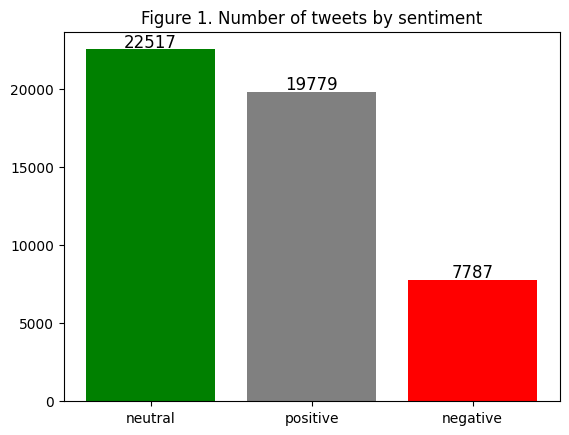

sentiment
neutral     22517
positive    19779
negative     7787
Name: count, dtype: int64


In [ ]:
#let us examine Number of tweets by sentiments
#val_co represents the value counts of the sentiments
val_co =merged_df["sentiment"].value_counts()
plt.bar(val_co.index, val_co.values, color =["green","grey","red"], )
plt.title("Figure 1. Number of tweets by sentiment")
for position, val in enumerate(val_co.values):
    plt.text(position, val+150, str(val), ha ='center', fontsize = 12)
plt.show()

print(val_co)

In [ ]:
#Visualizations of tweets
#aggregate tweets into stringsfor word cloud plotting
all_tweets = " ".join((merged_df["tweet"]))
neutral_tweets = ' '.join(merged_df[merged_df["sentiment"]=='neutral']["tweet"])
positive_tweets = ' '.join(merged_df[merged_df["sentiment"]=='positive']["tweet"])
negative_tweets = ' '.join(merged_df[merged_df["sentiment"]=='negative']["tweet"])

In [ ]:
#wordcloud for all the tweets
def plot_wordcloud(tweet_str:'string of tweets', title: 'title of plot'):
    wc = WordCloud(width = 1400, height = 1000).generate(tweet_str)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

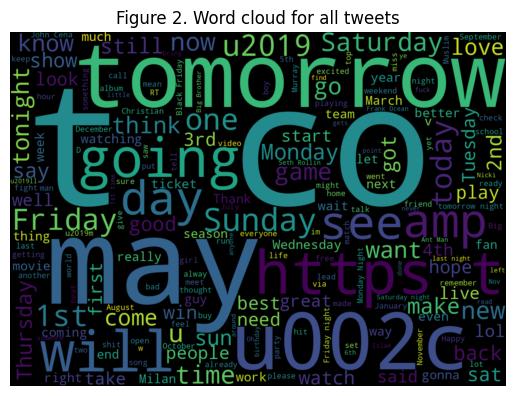

In [ ]:
#wordcloud for all the tweets
plot_wordcloud(tweet_str = all_tweets, title= "Figure 2. Word cloud for all tweets")

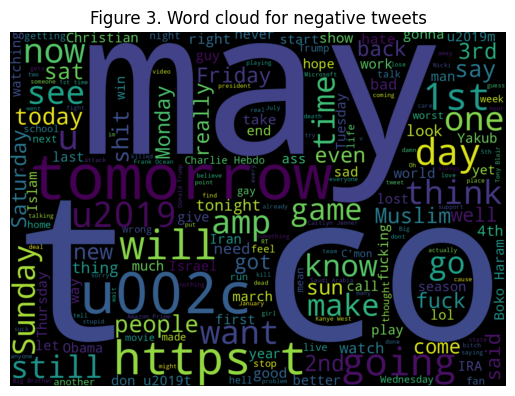

In [ ]:
plot_wordcloud(tweet_str= negative_tweets, title="Figure 3. Word cloud for negative tweets")

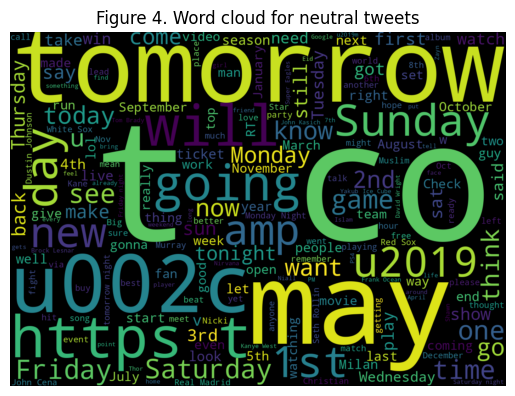

In [ ]:
#wordcloud for neutral tweets
plot_wordcloud(tweet_str= neutral_tweets, title = 'Figure 4. Word cloud for neutral tweets')

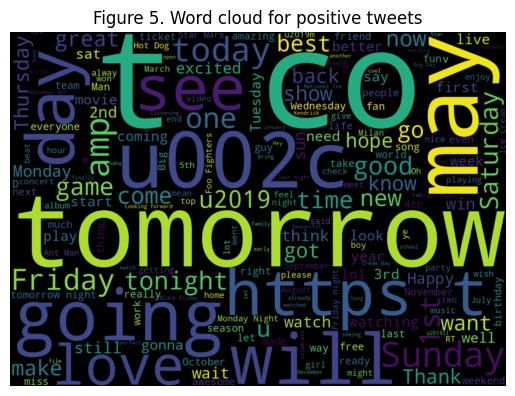

In [ ]:
#wordcloud for positive tweets
plot_wordcloud(tweet_str= positive_tweets, title= "Figure 5. Word cloud for positive tweets")

### Step 3: Data Cleaning

In [ ]:
merged_df.head()

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,id,sentiment,tweet,3
0,260097528899452929,neutral,Won the match #getin . Plus\u002c tomorrow is ...,NaN
1,263791921753882624,neutral,Some areas of New England could see the first ...,NaN
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony...,NaN
3,264041328420204544,neutral,#Thailand Washington - US President Barack Oba...,NaN
4,263816256640126976,neutral,Did y\u2019all hear what Tony Romo dressed up ...,NaN


In [ ]:
#We can see the fourth column has null entries and is different from other columns, so we will explore it.
merged_df[merged_df[3].notna()]

,id,sentiment,tweet,3
26301,626437371999977472,neutral,...Yakub may well deserve the finding of guilt...,Wed Jul 29 12:01:22 +0000 2015
27725,629712146016935936,neutral,Testing Motorola's Moto G 3rd-gen mobe: Is it ...,Fri Aug 07 11:54:09 +0000 2015
32061,636047266248265728,negative,"Scott Walker, who thinks ISIL compares to Amer...",Mon Aug 24 20:27:40 +0000 2015
32098,636112894086782976,neutral,@lindaikeji: Super Eagles coach Sunday Oliseh ...,Tue Aug 25 09:48:27 +0000 2015
33783,637879757124669440,neutral,@Roman_Empire_76: BREAKING NEWS Rock is ret...,Sun Aug 30 06:49:19 +0000 2015
35020,638624782955773952,neutral,Canada responded on Monday to GOP presidential...,Tue Sep 01 08:09:47 +0000 2015
39451,641496308705046528,neutral,Hatha yoga student would do well to learn abou...,Wed Sep 09 00:20:13 +0000 2015
40330,665676995036995584,neutral,This image was taken at a huge demonstration i...,Sat Nov 14 18:45:37 +0000 2015
40501,666696532993818624,neutral,"We are no longer where we were on 7 January, w...",Tue Nov 17 14:16:54 +0000 2015
43987,681451525240127488,negative,"ISIS is on the march, being bombed by everyone...",Mon Dec 28 14:27:59 +0000 2015


In [ ]:
# It seems the last column is likely supposed to be for time which is not useful for this task.
# This column will be dropped as it is not needed.
merged_df.drop(3, axis= 1, inplace = True)
merged_df.head()

,id,sentiment,tweet
0,260097528899452929,neutral,Won the match #getin . Plus\u002c tomorrow is ...
1,263791921753882624,neutral,Some areas of New England could see the first ...
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony...
3,264041328420204544,neutral,#Thailand Washington - US President Barack Oba...
4,263816256640126976,neutral,Did y\u2019all hear what Tony Romo dressed up ...


In [ ]:
#Check for null entries
print("Null entries: ")
print(merged_df.isna().sum())
print()

#Check  for duplicate entries
print("Duplicate entries: ")
print(merged_df.duplicated().sum())



Null entries: 
id           0
sentiment    0
tweet        0
dtype: int64

Duplicate entries: 
665


In [ ]:
# We have no null entries and 665 duplicate entries.
# Let us check the duplicate values before removing them
merged_df[merged_df.duplicated()].sort_values(by= 'tweet',ascending = False,) #to check all the occurrences of the duplicates use df.duplicated(keep = False)

,id,sentiment,tweet
19578,262791989945331712,neutral,was sat watching Degrassi then came to the rea...
19230,259651417738981376,neutral,uploading random pics! Lol this is me last Sun...
19172,102419013056999424,positive,today is the day we have been waiting for all ...
19606,205900257429692417,positive,till June 5 nalang ang botohan! So make sure y...
19403,262006730223927296,negative,this nigga @OctobersOwn91 just hit a full cour...
...,...,...,...
19453,248637158435459072,neutral,#FLEXTHURSDAY !! DIS THURSDAY!!!!!wit @FLEXCRE...
19452,248431915789611008,neutral,#FLEXTHURSDAY !! DIS THURSDAY!!!!!wit @FLEXCRE...
5252,264011728084410369,neutral,#Broncos Peyton Manning named AFC Offensive Pl...
19135,103277622636716032,positive,"#3words \""""Tonight's the night\"""" #dexter @SHO..."


In [ ]:
print(f"This is the shape with duplicates{merged_df.shape}")

#drop the duplicates
merged_df.drop_duplicates(inplace = True)
print()
print(f"This is the shape without duplicates{merged_df.shape}")

This is the shape with duplicates(50083, 3)

This is the shape without duplicates(49418, 3)


### Step 4: Data Preprocessing

There are three steps to NLP task; data preprocessing--> feature extraction--> appplication of ML/DL techniques
Now we have to preprocess the features which are the tweets in this experiment. These are the general steps for data preprocessing;
1. Lowercase the text #I can also use tweettokenizer for this
2. Remove URL
3. Remove usernames (This is peculiar to social media text) TweetTokenizer can also do this
4. Remove RT (This is peculiar to twitter)
5. Remove of hastags
6. Remove punctuation
7. Tokenize
8. Remove stop words #as described in the paper we will not be removing the stop words
9. Lemmatization of tweets
10. Joining of output

In [ ]:
#initialize WordNetLemmatizer for lemmatization
wnl = WordNetLemmatizer()

# Initialize TweetTokenizer
# The parameter strip_handles= True removes the usernames;
# reduce_len = True reduces characters repeated more than 3 times to 3
tweet_token = TweetTokenizer(strip_handles= True, reduce_len = True)

#function to automate the cleaning of tweets
def clean_tweet(tweet):
    # Convert text to lowercase
    tweet = tweet.lower()
    # Remove urls (Http(s) and www)
    tweet = re.sub(r'https?://\S+|www\.\S+', '', tweet)
    # Remove RT (which stands for retweet in twitter(might be common in tweets))
    tweet= re.sub(r'rt', "", tweet)
    # Remove hastags
    tweet=  re.sub(r'#', "", tweet)
    # Remove emojis
    tweet = emoji.replace_emoji(tweet,"")
    # Removes numbers
    tweet = re.sub(r'[0-9]+',"", tweet)
    #remove extra spaces
    tweet = re.sub(r'\s+'," ", tweet)

    #Tokenize tweet
    tokens = tweet_token.tokenize(tweet)
    clean_tokens = [] # container tokens without punctuations
    #in the method I am using I am not removing stop words.
    for word in tokens:
        if(word not in (string.punctuation)):
            clean_tokens.append((word))
    return clean_tokens

#function to get part of speech
def part_of_speech(word_tag):
    if word_tag.startswith('J'):
        return wordnet.ADJ
    elif word_tag.startswith('V'):
        return wordnet.VERB
    elif word_tag.startswith('N'):
        return wordnet.NOUN
    elif word_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


#We need to use this fuuction because pos_tag can only receive input of list of words and then supply the part of speech
def lemmatize_tweets(tweet_tokens):
    pos_tags = nltk.pos_tag(tweet_tokens)
    lemmatized_tweet_tokens = [wnl.lemmatize(word, part_of_speech(pos_tag)) for word, pos_tag in pos_tags]
    return lemmatized_tweet_tokens#rewrite

#This code shows the cleaning of a random tweet
example = ("@Banjiola 123exciting, I enjoyed Natural Langauge Processing todays. I am becoming a data scientist   #Coventry #NLP #AI")
test_clean = clean_tweet(example) # i need to remove punctutaions
print("Cleaned example:")
print(" ".join(test_clean))
print()
print("Lemmatization of cleaned example:")
print(" ".join(lemmatize_tweets(test_clean)))


Cleaned example:
exciting i enjoyed natural langauge processing todays i am becoming a data scientist coventry nlp ai

Lemmatization of cleaned example:
excite i enjoy natural langauge processing today i be become a data scientist coventry nlp ai


In [ ]:
#Preprocessing tweets
#Firstly clean the tweets
merged_df["clean_tweet"] = merged_df["tweet"].apply(clean_tweet) #list of clean individual words

#Then we lemmatize the tweets
merged_df["lemmatized_clean_tweet"] = merged_df["clean_tweet"].apply((lemmatize_tweets))

#Examine results
merged_df[["clean_tweet","lemmatized_clean_tweet"]]

,clean_tweet,lemmatized_clean_tweet
0,"[won, the, match, getin, plus, uc, tomorrow, i...","[win, the, match, getin, plus, uc, tomorrow, b..."
1,"[some, areas, of, new, england, could, see, th...","[some, area, of, new, england, could, see, the..."
2,"[nd, worst, qb, definitely, tony, romo, the, m...","[nd, bad, qb, definitely, tony, romo, the, man..."
3,"[thailand, washington, us, president, barack, ...","[thailand, washington, u, president, barack, o..."
4,"[did, y, uall, hear, what, tony, romo, dressed...","[do, y, uall, hear, what, tony, romo, dress, u..."
...,...,...
50078,"[ok, good, to, know, punting, at, metlife, in,...","[ok, good, to, know, punt, at, metlife, in, de..."
50079,"[everyone, who, sat, around, me, at, metlife, ...","[everyone, who, sit, around, me, at, metlife, ..."
50080,"[what, giants, or, niners, fans, would, wanna,...","[what, giants, or, niner, fan, would, wanna, g..."
50081,"[anybody, want, a, ticket, for, tomorrow, colo...","[anybody, want, a, ticket, for, tomorrow, colo..."


In [ ]:
#now we join the tweets
merged_df["lemmatized_clean_tweet"] = merged_df["lemmatized_clean_tweet"].apply(lambda words: " ".join(words))
merged_df[["lemmatized_clean_tweet"]]

,lemmatized_clean_tweet
0,win the match getin plus uc tomorrow be a very...
1,some area of new england could see the first f...
2,nd bad qb definitely tony romo the man who lik...
3,thailand washington u president barack obama v...
4,do y uall hear what tony romo dress up a for h...
...,...
50078,ok good to know punt at metlife in december be...
50079,everyone who sit around me at metlife be so an...
50080,what giants or niner fan would wanna go to the...
50081,anybody want a ticket for tomorrow colombia v ...


### Step 5: Feature Extratction
After data preprocessing the next step is the feature extraction. We need to convert words into numbers that a machine leaning model will understand. This is done using Bag of Words (BOW) and Term Frequency Inverse Document Frequency (TF-IDF)

#### 5.1 TF-IDF

In [ ]:

#initialize label encoder for sentiments column
le = LabelEncoder()
#Label encode sentiment
merged_df["sentiment_encoded"] = le.fit_transform(merged_df["sentiment"])
#split feature and target variables
X = merged_df["lemmatized_clean_tweet"]
y = merged_df["sentiment_encoded"]
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, random_state = 70)


#Initialize TF_IDF
tf_idf = TfidfVectorizer()
X_train_tf_idf = tf_idf.fit_transform(X_train)
X_test_tf_idf = tf_idf.transform(X_test)
print(X_train_tf_idf.shape)
print(X_test_tf_idf.shape)


(34592, 30767)
(14826, 30767)


#### 5.2 BOW

In [ ]:
#Initialize bag of words
bow = CountVectorizer()
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

### Step 6: Application of Machine Learning Algorithms
The last step for sentiment analysis is the application of machine learing or deep learning model. For this course work I will be using five machine learning models for this classification problem
1. Logistic Regression
2. Naive Bayes
3. Support Vector Machine
4. Random Forest
5. XGBoost


#### 6A: Using the features extracted by TFIDF

##### Model 1: Logistic Regression (TFIDF)

In [ ]:
#max_iter is the number of times my optimization algorithm will run until it converges
lr_model_tfidf = LogisticRegression(solver ="lbfgs", max_iter = 1000, random_state= 70 )

#train model and make predictions
lr_model_tfidf.fit(X_train_tf_idf, y_train)
y_hat1_tfidf = lr_model_tfidf.predict(X_test_tf_idf)

#evaluation metrics
print(f"The accuracy score  for Logistic regression(TFIDF) {accuracy_score(y_test, y_hat1_tfidf)}")
print()
print("Classification report for Logistic regression(TFIDF)")
print(classification_report(y_test, y_hat1_tfidf))


The accuracy score  for Logistic regression(TFIDF) 0.6579657358694186

Classification report for Logistic regression(TFIDF)
              precision    recall  f1-score   support

           0       0.63      0.36      0.46      2240
           1       0.63      0.76      0.69      6621
           2       0.71      0.66      0.68      5965

    accuracy                           0.66     14826
   macro avg       0.65      0.59      0.61     14826
weighted avg       0.66      0.66      0.65     14826



##### Model 2: Multinomial Naive Bayes Classifier (TFIDF)

In [ ]:
#initialize model
nb_model_tfidf = MultinomialNB()

#train and make predictions
nb_model_tfidf.fit(X_train_tf_idf,y_train)
y_hat2_tfidf = nb_model_tfidf.predict(X_test_tf_idf)

#Evaluation Metrics
print(f"Accuracy: {accuracy_score(y_test,y_hat2_tfidf)}")
print()
print("Classification Report for Multinomial Naive Bayes Clasifier")
print(classification_report(y_test, y_hat2_tfidf))

Accuracy: 0.6074463779846216

Classification Report for Multinomial Naive Bayes Clasifier
              precision    recall  f1-score   support

           0       0.84      0.01      0.02      2240
           1       0.57      0.79      0.66      6621
           2       0.67      0.63      0.65      5965

    accuracy                           0.61     14826
   macro avg       0.69      0.48      0.44     14826
weighted avg       0.65      0.61      0.56     14826



##### Model 3: Support Vector Machines (TFIDF)

In [ ]:
#initialize model
svc_model_tfidf = SVC(kernel = 'linear', random_state = 70)

#train model and make predictions
svc_model_tfidf.fit(X_train_tf_idf,y_train)
y_hat3_tfidf = svc_model_tfidf.predict(X_test_tf_idf)

#Evaluation Metrics
print(f"Accuracy: {accuracy_score(y_test, y_hat3_tfidf)}")
print("Classification Report:")
print(classification_report(y_test,y_hat3_tfidf))


Accuracy: 0.6591798192364765
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.40      0.49      2240
           1       0.62      0.77      0.69      6621
           2       0.72      0.64      0.68      5965

    accuracy                           0.66     14826
   macro avg       0.66      0.60      0.62     14826
weighted avg       0.66      0.66      0.65     14826



##### Model 4: Random Forest (TFIDF)

In [ ]:
#initialize model
rfc_model_tfidf = RandomForestClassifier(random_state= 70)

#train and make predictions
rfc_model_tfidf.fit(X_train_tf_idf, y_train)
y_hat4_tfidf= rfc_model_tfidf.predict(X_test_tf_idf)

#Evaluation Metrics
print(f"Accuracy: {accuracy_score(y_test,y_hat4_tfidf)}")
print("Classification Report")
print(classification_report(y_test,y_hat4_tfidf))

Accuracy: 0.6215432348576825
Classification Report
              precision    recall  f1-score   support

           0       0.71      0.09      0.17      2240
           1       0.58      0.81      0.68      6621
           2       0.69      0.61      0.65      5965

    accuracy                           0.62     14826
   macro avg       0.66      0.50      0.50     14826
weighted avg       0.64      0.62      0.59     14826



##### Model 5: XGBoost (TFIDF)

In [ ]:
#initialize model
xgb_tfidf = XGBClassifier()

#train and make predictions
xgb_tfidf.fit(X_train_tf_idf, y_train)
y_hat5_tfidf = xgb_tfidf.predict(X_test_tf_idf)

#Evaluation Metrics
print(f"Accuracy: {accuracy_score(y_test,y_hat5_tfidf)}")
print("Classification Report")
print(classification_report(y_test,y_hat5_tfidf))

Accuracy: 0.6404289761230271
Classification Report
              precision    recall  f1-score   support

           0       0.62      0.27      0.37      2240
           1       0.59      0.84      0.69      6621
           2       0.74      0.56      0.64      5965

    accuracy                           0.64     14826
   macro avg       0.65      0.56      0.57     14826
weighted avg       0.66      0.64      0.62     14826



#### 6B: Using the features extracted by BOW

##### Model 1: Logistic Regression (BOW)

In [ ]:
lr_model_bow = LogisticRegression(solver ="lbfgs", max_iter = 1000, random_state= 70 ) #max_iter is the number of times my optimization algorithm will run unitl it converges
#train model and make predictions
lr_model_bow.fit(X_train_bow, y_train)
y_hat1_bow = lr_model_bow.predict(X_test_bow)

#evaluation metrics
print(f"The accruacy score  for Logistic regression BOW {accuracy_score(y_test, y_hat1_bow)}")
print()
print("Classification report for Logistic regression BOW")
print(classification_report(y_test, y_hat1_bow))


The accruacy score  for Logistic regression BOW 0.647376230945636

Classification report for Logistic regression BOW
              precision    recall  f1-score   support

           0       0.57      0.44      0.50      2240
           1       0.63      0.71      0.67      6621
           2       0.70      0.65      0.68      5965

    accuracy                           0.65     14826
   macro avg       0.63      0.60      0.61     14826
weighted avg       0.65      0.65      0.64     14826



##### Model 2: Multinomial Naive Bayes Classifier (BOW)

In [ ]:
nb_model_bow = MultinomialNB()

#train and make predictions
nb_model_bow.fit(X_train_bow,y_train)
y_hat2_bow = nb_model_bow.predict(X_test_bow)

#Evaluation metrics
print(f"Accuracy: {accuracy_score(y_test,y_hat2_bow)}")
print()
print("Classification Report for Multinomial Naive Bayes Clasifier")
print(classification_report(y_test, y_hat2_bow))

Accuracy: 0.6293673276676109

Classification Report for Multinomial Naive Bayes Clasifier
              precision    recall  f1-score   support

           0       0.58      0.36      0.45      2240
           1       0.63      0.65      0.64      6621
           2       0.64      0.71      0.67      5965

    accuracy                           0.63     14826
   macro avg       0.62      0.57      0.59     14826
weighted avg       0.63      0.63      0.62     14826



##### Model 3: Support Vector Machines (BOW)

In [ ]:
svc_model_bow = SVC(kernel = 'linear', random_state = 70)

#train model and make predictions
svc_model_bow.fit(X_train_bow,y_train)
y_hat3_bow = svc_model_bow.predict(X_test_bow)

#Evaluation Metrics
print(f"Accuracy: {accuracy_score(y_test, y_hat3_bow)}")
print("Classification Report:")
print(classification_report(y_test,y_hat3_bow))


Accuracy: 0.632132739781465
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.48      0.48      2240
           1       0.63      0.68      0.65      6621
           2       0.69      0.64      0.67      5965

    accuracy                           0.63     14826
   macro avg       0.60      0.60      0.60     14826
weighted avg       0.63      0.63      0.63     14826



##### Model 4: Random Forest(BOW)

In [ ]:
#Initialize model
rfc_model_bow = RandomForestClassifier(n_estimators= 70, random_state= 70)

#Train and make predictions
rfc_model_bow.fit(X_train_bow, y_train)
y_hat4_bow = rfc_model_bow.predict(X_test_bow)

#Evaluation metrics
print(f"Accuracy: {accuracy_score(y_test,y_hat4_bow)}")
print()
print("Classification Report")
print(classification_report(y_test,y_hat4_bow))

Accuracy: 0.6232969108323216

Classification Report
              precision    recall  f1-score   support

           0       0.69      0.10      0.18      2240
           1       0.58      0.84      0.68      6621
           2       0.71      0.58      0.64      5965

    accuracy                           0.62     14826
   macro avg       0.66      0.51      0.50     14826
weighted avg       0.65      0.62      0.59     14826



##### Model 5: XGBoost

In [ ]:
model_a_bow = XGBClassifier()

#train and make predictions
model_a_bow.fit(X_train_bow, y_train)
y_hat_bow = model_a_bow.predict(X_test_bow)

#Evaluation Metrics
print(f"Accuracy: {accuracy_score(y_test,y_hat_bow)}")
print("Classification Report")
print(classification_report(y_test,y_hat_bow))

Accuracy: 0.6422501011736139
Classification Report
              precision    recall  f1-score   support

           0       0.66      0.27      0.39      2240
           1       0.59      0.85      0.70      6621
           2       0.75      0.55      0.63      5965

    accuracy                           0.64     14826
   macro avg       0.67      0.56      0.57     14826
weighted avg       0.67      0.64      0.63     14826



### Confusion Matrix for Top three models

In [ ]:
def plot_conf_matrix(pred, title):
    # pred: the prediction
    # title(str): name this for individual plots
    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels= ["Negative", "Neutral","positive"], yticklabels= ["Negative", "Neutral","positive"])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(f'{title}.svg')
    plt.title(title)
    plt.show()

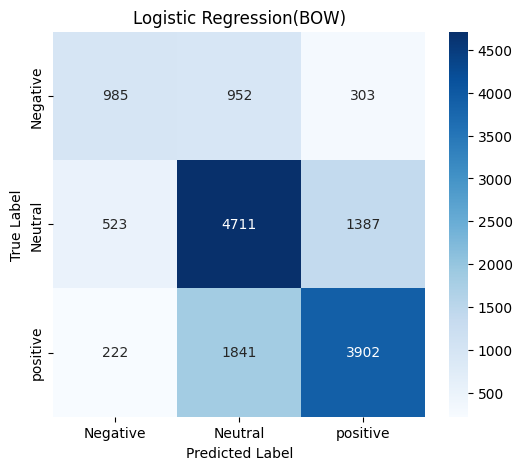

In [ ]:
plot_conf_matrix(pred= y_hat1_bow,title= 'Logistic Regression(BOW)')

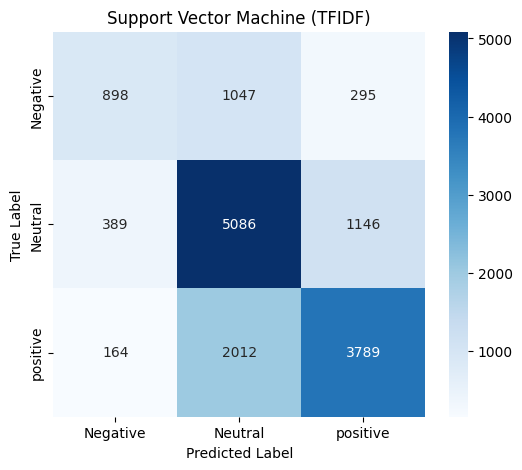

In [ ]:
plot_conf_matrix(pred= y_hat3_tfidf,title= 'Support Vector Machine (TFIDF)')

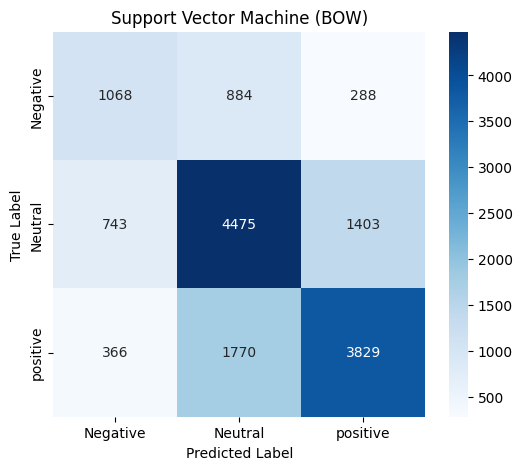

In [ ]:
plot_conf_matrix(pred= y_hat3_bow,title= 'Support Vector Machine (BOW)')